<a href="https://colab.research.google.com/github/muhdhady/mangrove-classifier/blob/main/ann_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installs (run once)
!pip install rasterio
!pip install tensorflow
!pip install tf_keras

In [ ]:
# Imports
import os
from pathlib import Path
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import json
import math
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tf_keras  # for AdamW, BatchNorm/GroupNorm, etc.
from sklearn.metrics import f1_score, confusion_matrix, jaccard_score, classification_report
from skimage.morphology import opening, closing, disk
import seaborn as sns
from scipy import ndimage
import matplotlib.colors as mcolors
from rasterio.warp import reproject, Resampling, calculate_default_transform
from scipy.ndimage import shift
import shutil
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import tf_keras.backend as K


In [ ]:
# Step 0: Mount Drive & Verify Files

# Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CONFIG
# Define roots and expected files
DE_ROOT = "/content/drive/MyDrive/ANN_Project/deepmind"
GMW_ROOT = "/content/drive/MyDrive/ANN_Project/gmw"
EXPECTED_YEARS = ["2017.tif", "2018.tif", "2019.tif", "2020.tif"]

# Define regions and years
REGIONS = sorted(os.listdir(DE_ROOT))
YEARS = EXPECTED_YEARS

# Define output folders
DE_CORRECTED = "/content/drive/MyDrive/ANN_Project/deepmind_corrected"
GMW_CORRECTED = "/content/drive/MyDrive/ANN_Project/gmw_corrected"
OUT_ROOT = "/content/drive/MyDrive/ANN_Project/tiles"

# Regions
TRAIN_REGIONS = ["AbuDhabi", "Australia", "Mexico"]
TEST_REGION = "UmmAlQuwain"
VAL_REGION = "SaudiArabia"
TRAINVAL_REGIONS = TRAIN_REGIONS + [VAL_REGION]
ALL_REGIONS = TRAIN_REGIONS + [TEST_REGION] + [VAL_REGION]

# Tile params
TILE_SIZE = 128
TRAIN_OVERLAP = 64
VAL_TEST_OVERLAP = 0
BATCH_SIZE = 32
CHANNELS = 64  # number of input channels (DeepMind embeddings)

# Model
UNET_DEPTH = 4
FILTERS = [64, 128, 256, 512]
DROPOUT = 0.1
NORM = "batch"  # "batch" for BatchNorm

# Training
EPOCHS = 50
LR = 1e-4
WEIGHT_DECAY = 1e-4
CLIPNORM = 1.0
WARMUP_EPOCHS = 5

# Loss
FOCAL_GAMMA = 2.0

# Augmentation
AUGMENT_TRAIN = True
# Filtering
MIN_MANGROVE_FRACTION = 0.001
MIN_NEGATIVE_TILES_PER_REGION = 50000

# Splits
VAL_FRACTION = 0.10
SPLITS = ["train", "val"]

# Random seed
RANDOM_SEED = 42

# Step 3: Data loading / batch config
SHUFFLE = True  # shuffle training data
NUM_WORKERS = 2  # not used in Keras Sequence, can use tf.data for parallelism if needed

# Paths (after tiling)
TRAIN_META = os.path.join(OUT_ROOT, "train", "meta.jsonl")
VAL_META   = os.path.join(OUT_ROOT, "val", "meta.jsonl")

# Postprocessing parameters
MORPH_KERNEL_SIZE = 3  # for morphological operations


In [ ]:
# File verification function
def verify_directory(root, label):
    print(f"Checking {label} directory: {root}")

    if not os.path.exists(root):
        print(f"❌ Directory does NOT exist: {root}")
        return

    regions = sorted(os.listdir(root))
    print(f"Found {len(regions)} region folders: {regions}\n")

    for region in regions:
        region_path = os.path.join(root, region)

        if not os.path.isdir(region_path):
            print(f"⚠️ Skipping non-folder item: {region}")
            continue

        print(f"--- Region: {region} ---")
        region_files = sorted(os.listdir(region_path))

        # Check expected years
        missing = [year for year in EXPECTED_YEARS if year not in region_files]
        extra = [f for f in region_files if f not in EXPECTED_YEARS]

        if len(missing) == 0:
            print("   ✅ All expected files present:", EXPECTED_YEARS)
        else:
            print("   ❌ Missing:", missing)

        if len(extra) > 0:
            print("   ⚠️ Extra files:", extra)

        print()

# Run checks for both DE and GMW
verify_directory(DE_ROOT, "DeepMind Embeddings")
verify_directory(GMW_ROOT, "GMW Labels")


Checking DeepMind Embeddings directory: /content/drive/MyDrive/ANN_Project/deepmind
Found 5 region folders: ['AbuDhabi', 'Australia', 'Mexico', 'SaudiArabia', 'UmmAlQuwain']

--- Region: AbuDhabi ---
   ✅ All expected files present: ['2017.tif', '2018.tif', '2019.tif', '2020.tif']

--- Region: Australia ---
   ✅ All expected files present: ['2017.tif', '2018.tif', '2019.tif', '2020.tif']

--- Region: Mexico ---
   ✅ All expected files present: ['2017.tif', '2018.tif', '2019.tif', '2020.tif']

--- Region: SaudiArabia ---
   ✅ All expected files present: ['2017.tif', '2018.tif', '2019.tif', '2020.tif']

--- Region: UmmAlQuwain ---
   ✅ All expected files present: ['2017.tif', '2018.tif', '2019.tif', '2020.tif']

Checking GMW Labels directory: /content/drive/MyDrive/ANN_Project/gmw
Found 5 region folders: ['AbuDhabi', 'Australia', 'Mexico', 'SaudiArabia', 'UmmAlQuwain']

--- Region: AbuDhabi ---
   ✅ All expected files present: ['2017.tif', '2018.tif', '2019.tif', '2020.tif']

--- Region:

In [ ]:
# Check for NaNs
def check_nans_all(root, label):
    regions = sorted(os.listdir(root))
    print(f"\nChecking NaNs for {label} in {root}\n")

    for region in regions:
        region_path = os.path.join(root, region)
        if not os.path.isdir(region_path):
            continue
        for year in EXPECTED_YEARS:
            file_path = os.path.join(region_path, year)
            if not os.path.exists(file_path):
                print(f"❌ Missing file: {file_path}")
                continue

            with rasterio.open(file_path) as src:
                arr = src.read().astype(float)

            n_nans = np.isnan(arr).sum()
            total = arr.size
            print(f"{region}/{year}: {n_nans} NaNs out of {total} pixels ({n_nans/total:.2%})")

# Run checks
# check_nans_all(DE_ROOT, "DeepMind Embeddings")
# check_nans_all(GMW_ROOT, "GMW Labels")

Starting alignment and correction process...

--- VISUAL CHECK: AbuDhabi 2017.tif ---


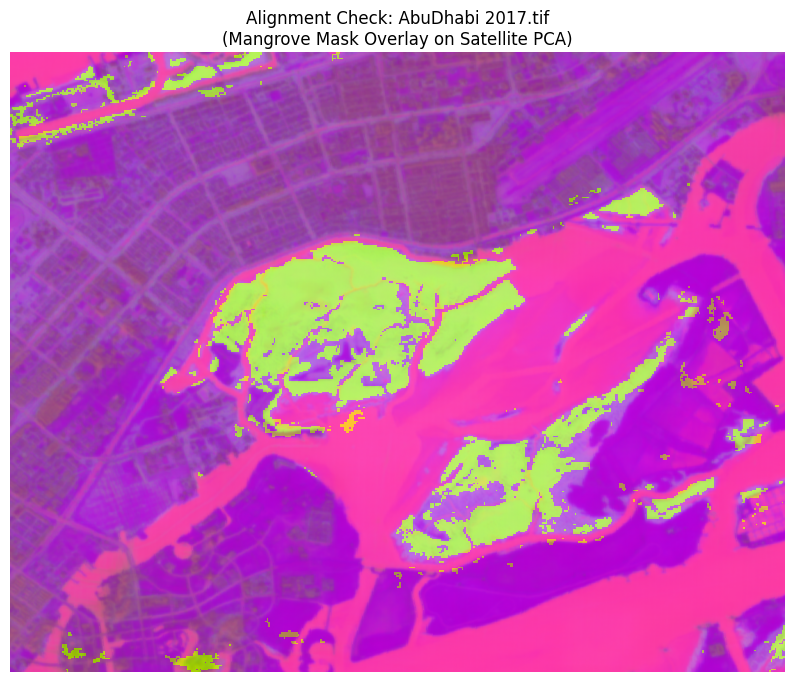

Check the edges! The mask (Pink/Red) should align PERFECTLY with the trees.
Finished Region: AbuDhabi
Finished Region: Australia
Finished Region: Mexico
Finished Region: SaudiArabia
Finished Region: UmmAlQuwain
All files corrected and aligned.


In [ ]:
# Step 1: Loading
# --- CONFIGURATION (Ensure these are defined) ---
# DE_ROOT, GMW_ROOT, DE_CORRECTED, GMW_CORRECTED, REGIONS, EXPECTED_YEARS

def align_and_save(src_path, dst_ref_path, out_path, is_mask=False):
    """
    Reads 'src_path' and warps it to match the EXACT grid (transform, CRS, shape)
    of 'dst_ref_path'. This fixes misalignment and flipping issues.
    """
    # 1. Open the Reference (The grid we want to match)
    with rasterio.open(dst_ref_path) as ref:
        dst_crs = ref.crs
        dst_transform = ref.transform
        dst_height = ref.height
        dst_width = ref.width

    # 2. Open the Source (The file we want to fix)
    with rasterio.open(src_path) as src:
        # Prepare output metadata based on the Reference
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': dst_transform,
            'width': dst_width,
            'height': dst_height,
            'driver': 'GTiff',
            'compress': 'lzw'
        })

        # 3. Create destination array
        # (bands, height, width)
        destination = np.zeros((src.count, dst_height, dst_width), dtype=src.dtypes[0])

        # 4. Reproject (Warp)
        resampling = Resampling.bilinear if is_mask else Resampling.nearest

        reproject(
            source=rasterio.band(src, src.indexes),
            destination=destination,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=resampling
        )

        # 5. Save
        with rasterio.open(out_path, 'w', **kwargs) as dst:
            dst.write(destination)

# --- MAIN EXECUTION ---
os.makedirs(DE_CORRECTED, exist_ok=True)
os.makedirs(GMW_CORRECTED, exist_ok=True)

visualized_one = False  # Flag to ensure we only plot once

print("Starting alignment and correction process...")

for region in REGIONS:
    region_de_out = os.path.join(DE_CORRECTED, region)
    region_gmw_out = os.path.join(GMW_CORRECTED, region)
    os.makedirs(region_de_out, exist_ok=True)
    os.makedirs(region_gmw_out, exist_ok=True)

    for year in EXPECTED_YEARS:
        # Paths
        de_raw = os.path.join(DE_ROOT, region, year)
        gmw_raw = os.path.join(GMW_ROOT, region, year)

        de_out = os.path.join(region_de_out, year)
        gmw_out = os.path.join(region_gmw_out, year)

        # 1. Process GMW (Target) first.
        # We copy it to the output folder (updating it to standard North-Up if needed)
        # to serve as the 'Master Grid' for this year.
        with rasterio.open(gmw_raw) as src:
            # We treat the raw GMW as the ground truth grid.
            # If GMW itself needs flipping, rasterio.warp inside align_and_save can handle it
            # if we aligned it to itself, but simpler is to just write it out standardized.
            # For safety, let's just use align_and_save against itself to ensure standard transform.
            align_and_save(gmw_raw, gmw_raw, gmw_out, is_mask=True)

        # 2. Process DE (Input).
        # We align DE to match the NEW GMW grid exactly.
        align_and_save(de_raw, gmw_out, de_out, is_mask=False)

        # --- VISUALIZATION CHECK (Run Once) ---
        if not visualized_one:
            print(f"\n--- VISUAL CHECK: {region} {year} ---")

            # Load the files we just wrote
            with rasterio.open(de_out) as src_de:
                de_arr = src_de.read() # (C, H, W)
            with rasterio.open(gmw_out) as src_gmw:
                gmw_arr = src_gmw.read(1) # (H, W)

            # PCA for DE (DeepMind embeddings)
            C, H, W = de_arr.shape
            flat = de_arr.reshape(C, -1).T
            pca = PCA(n_components=3)
            rgb_flat = pca.fit_transform(flat)
            rgb = rgb_flat.reshape(H, W, 3)
            # Normalize to 0-1 for plotting
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

            # Plot
            plt.figure(figsize=(10, 10))
            plt.title(f"Alignment Check: {region} {year}\n(Mangrove Mask Overlay on Satellite PCA)")
            plt.imshow(rgb)
            # Overlay GMW in bright red or green
            plt.imshow(gmw_arr, cmap="spring", alpha=0.5, interpolation='none')
            plt.axis("off")
            plt.show()

            print("Check the edges! The mask (Pink/Red) should align PERFECTLY with the trees.")
            visualized_one = True

    print(f"Finished Region: {region}")

print("All files corrected and aligned.")

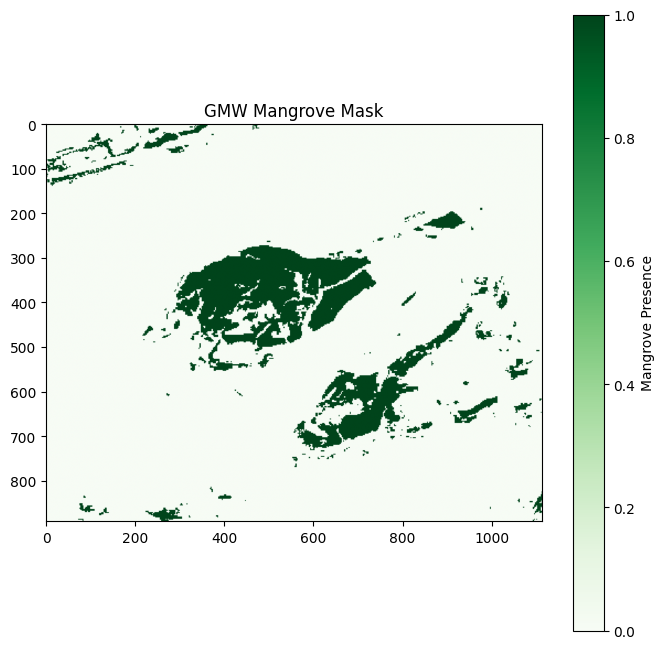

In [ ]:
# Random GMW check after correction
gmw_path = "/content/drive/MyDrive/ANN_Project/gmw_corrected/AbuDhabi/2018.tif"

# Open with rasterio
with rasterio.open(gmw_path) as src:
    gmw_arr = src.read(1)  # read first (and usually only) band
    profile = src.profile

# Display
plt.figure(figsize=(8, 8))
plt.imshow(gmw_arr, cmap='Greens')
plt.title("GMW Mangrove Mask")
plt.colorbar(label="Mangrove Presence")
plt.show()


In [ ]:
# Inspecting features and labels
def load_raster(path):
        with rasterio.open(path) as src:
          arr = src.read()
        return arr

def inspect_features():
        for region in REGIONS:
          print(f"\n=== Region: {region} ===")
          for year in YEARS:
            de_path = os.path.join(DE_ROOT, region, year)
            gmw_path = os.path.join(GMW_ROOT, region, year)

            # Load DeepMind embeddings
            de = load_raster(de_path)  # shape: (64, H, W)
            de_min = de.min(axis=(1,2))
            de_max = de.max(axis=(1,2))
            de_mean = de.mean(axis=(1,2))
            de_std = de.std(axis=(1,2))

            print(f"\nYear {year} - DeepMind embeddings:")
            for b in range(de.shape[0]):
                print(f"  Band {b+1}: min={de_min[b]:.3f}, max={de_max[b]:.3f}, mean={de_mean[b]:.3f}, std={de_std[b]:.3f}")

            # Load GMW labels
            gmw = load_raster(gmw_path)  # shape: (1, H, W) or (H,W)
            gmw_unique = np.unique(gmw)
            gmw_fraction = np.sum(gmw==1)/gmw.size
            print(f"Year {year} - GMW labels: unique={gmw_unique}, fraction mangrove={gmw_fraction:.3%}")

# inspect_features()

In [ ]:
# Step 2: Tiling and splitting
# Helper functions and directories
def read_raster_and_mask(path):
    with rasterio.open(path) as src:
        arr = src.read()
        mask = src.read_masks(1)
        mask = (mask > 0).astype(np.uint8)
        profile = src.profile.copy()
    return arr, mask, profile

def save_npy(arr, path):
    np.save(path, arr, allow_pickle=False)

def meta_write(split, record):
    with open(meta_paths[split], "a") as f:
        f.write(json.dumps(record) + "\n")

def iter_tiles(image_shape, tile_size=TILE_SIZE, step=TILE_SIZE):
    H, W = image_shape
    n_i = math.ceil((H - tile_size) / step) + 1
    n_j = math.ceil((W - tile_size) / step) + 1
    for i_idx in range(n_i):
        for j_idx in range(n_j):
            i = min(i_idx * step, H - tile_size)
            j = min(j_idx * step, W - tile_size)
            yield i, j

# Create directories
for split in SPLITS:
    for sub in ["X", "Y", "mask"]:
        os.makedirs(os.path.join(OUT_ROOT, split, sub), exist_ok=True)

# Metadata paths
meta_paths = {split: os.path.join(OUT_ROOT, split, "meta.jsonl") for split in SPLITS}
for p in meta_paths.values():
    if os.path.exists(p):
        os.remove(p)

In [ ]:
# 1. Define Local Output Path (FAST SSD)
LOCAL_OUT_ROOT = "/content/temp_tiles"

# 2. Prepare Directories
print("Setting up local directories...")
if os.path.exists(LOCAL_OUT_ROOT):
    shutil.rmtree(LOCAL_OUT_ROOT) # Clean start

for split in ["train", "val"]:
    for sub in ["X", "Y", "mask"]:
        os.makedirs(os.path.join(LOCAL_OUT_ROOT, split, sub), exist_ok=True)

# Local metadata paths
TRAIN_META_LOCAL = os.path.join(LOCAL_OUT_ROOT, "train", "meta.jsonl")
VAL_META_LOCAL = os.path.join(LOCAL_OUT_ROOT, "val", "meta.jsonl")

# Lists to hold records
train_records = []
val_records = []

print(f"STARTING tiling over regions: {TRAINVAL_REGIONS}")

# --- MAIN TILING LOOP ---
for region in TRAINVAL_REGIONS:
    print(f"\n--- Processing region: {region} ---")

    # FIX 1: Determine split at the REGION level (Before the loop)
    # This ensures the very first tile gets the correct split assignment.
    if region == VAL_REGION:
        split = "val"
    else:
        split = "train"

    neg_saved_count = 0

    for year_idx, year in enumerate(YEARS[:-1]):  # skip last year
        next_year = YEARS[year_idx + 1]

        de_path = os.path.join(DE_CORRECTED, region, year)
        gmw_path = os.path.join(GMW_CORRECTED, region, next_year)

        # Check for existence
        if not (os.path.exists(de_path) and os.path.exists(gmw_path)):
            print(f"Missing {region}/{year}, skipping.")
            continue

        # Load rasters (Assumes ALIGNED data from Step 1)
        de_arr, de_mask, _ = read_raster_and_mask(de_path)
        gmw_arr, gmw_mask, _ = read_raster_and_mask(gmw_path)

        # Standardize dimensions
        if de_arr.ndim == 2:
            de_arr = de_arr[None, ...]
        if gmw_arr.ndim == 3 and gmw_arr.shape[0] == 1:
            gmw_arr = gmw_arr[0]

        H, W = de_arr.shape[1], de_arr.shape[2]

        # Robust Crop: Handle slight 1-pixel mismatches from alignment/rounding
        h_min = min(H, gmw_arr.shape[0])
        w_min = min(W, gmw_arr.shape[1])

        de_arr = de_arr[:, :h_min, :w_min]
        gmw_arr = gmw_arr[:h_min, :w_min]
        de_mask = de_mask[:h_min, :w_min]
        gmw_mask = gmw_mask[:h_min, :w_min]
        H, W = h_min, w_min

        # Create Validity Mask (Where both Satellite AND Label exist)
        valid_mask = ((de_mask > 0) & (gmw_mask > 0)).astype(np.uint8)

        # Determine Step Size
        step = TRAIN_OVERLAP if split == "train" else TILE_SIZE
        n_tiles_region_year = 0

        # Iterate Tiles
        for (i, j) in iter_tiles((H, W), step=step):
            # 1. Quick Mask Check (Optimization)
            mask_tile = valid_mask[i:i+TILE_SIZE, j:j+TILE_SIZE].astype(np.uint8)
            if mask_tile.sum() == 0:
                continue

            # 2. Extract Data
            de_tile = de_arr[:, i:i+TILE_SIZE, j:j+TILE_SIZE].astype(np.float32)
            gmw_tile = gmw_arr[i:i+TILE_SIZE, j:j+TILE_SIZE].astype(np.uint8)

            # 3. Edge Case Check
            if de_tile.shape[1] != TILE_SIZE or de_tile.shape[2] != TILE_SIZE:
                continue

            # 4. Calculate Statistics
            mangrove_pixels = ((gmw_tile == 1) & (mask_tile == 1)).sum()
            valid_pixels = mask_tile.sum()
            mangrove_fraction = mangrove_pixels / float(valid_pixels) if valid_pixels > 0 else 0.0
            is_positive = mangrove_fraction > 0

            # 5. Negative Filtering (Train Only)
            # Safe now because 'split' is defined correctly above
            if split == "train":
                if not is_positive and neg_saved_count >= MIN_NEGATIVE_TILES_PER_REGION:
                    continue

            # 6. Generate Filenames
            tile_id = f"{region}_{year.replace('.tif','')}_r{i}_c{j}"
            x_fname = f"{tile_id}_X.npy"
            y_fname = f"{tile_id}_Y.npy"
            m_fname = f"{tile_id}_mask.npy"

            # Use LOCAL_OUT_ROOT for speed
            x_out = os.path.join(LOCAL_OUT_ROOT, split, "X", x_fname)
            y_out = os.path.join(LOCAL_OUT_ROOT, split, "Y", y_fname)
            m_out = os.path.join(LOCAL_OUT_ROOT, split, "mask", m_fname)

            # FIX 2: NO AUGMENTATION HERE
            # We save the clean, original tile.
            # Random flips/rotations happen in the DataGenerator.

            # 7. Save to Local SSD
            save_npy(de_tile, x_out)
            save_npy(gmw_tile, y_out)
            save_npy(mask_tile, m_out)

            # 8. Record Metadata
            rec = {
                "tile_id": tile_id,
                "region": region,
                "year": year.replace('.tif',''),
                "next_year": next_year.replace('.tif',''),
                "i": i,
                "j": j,
                "mangrove_fraction": float(mangrove_fraction),
                "valid_pixels": int(valid_pixels),
                "is_positive": bool(is_positive),
                "x_path": x_out,    # Local path (will need updating if reading from Drive later)
                "y_path": y_out,
                "mask_path": m_out
            }

            if split == "train":
                train_records.append(rec)
            elif split == "val":
                val_records.append(rec)

            if not is_positive:
                neg_saved_count += 1

            n_tiles_region_year += 1

        print(f"  Year {year}: {n_tiles_region_year} tiles")
    print(f"Finished {region}, negatives kept: {neg_saved_count}")

print("Tiling finished on local disk.")
print("Writing metadata locally...")
with open(TRAIN_META_LOCAL, 'w') as f:
    for rec in train_records:
        f.write(json.dumps(rec) + '\n')

with open(VAL_META_LOCAL, 'w') as f:
    for rec in val_records:
        f.write(json.dumps(rec) + '\n')

Setting up local directories...
STARTING tiling over regions: ['AbuDhabi', 'Australia', 'Mexico', 'SaudiArabia']

--- Processing region: AbuDhabi ---
  Year 2017.tif: 221 tiles
  Year 2018.tif: 221 tiles
  Year 2019.tif: 221 tiles
Finished AbuDhabi, negatives kept: 201

--- Processing region: Australia ---
  Year 2017.tif: 286 tiles
  Year 2018.tif: 286 tiles
  Year 2019.tif: 286 tiles
Finished Australia, negatives kept: 175

--- Processing region: Mexico ---
  Year 2017.tif: 289 tiles
  Year 2018.tif: 289 tiles
  Year 2019.tif: 289 tiles
Finished Mexico, negatives kept: 373

--- Processing region: SaudiArabia ---
  Year 2017.tif: 234 tiles
  Year 2018.tif: 234 tiles
  Year 2019.tif: 234 tiles
Finished SaudiArabia, negatives kept: 582
Tiling finished on local disk.
Writing metadata locally...


In [ ]:
print("\nTILING COMPLETE!")
print(f"Train tiles: {len(train_records)}")
print(f"Val tiles:   {len(val_records)}")
print(f"Saved to: {OUT_ROOT}")



TILING COMPLETE!
Train tiles: 2388
Val tiles:   702
Saved to: /content/drive/MyDrive/ANN_Project/tiles


In [ ]:
# Step 3: Data loading
def load_and_preprocess_tile(x_path, y_path, augment):
    # 1. Convert TF string tensors -> Python strings
    x_path = x_path.numpy().decode("utf-8")
    y_path = y_path.numpy().decode("utf-8")

    # 2. Load arrays
    X = np.load(x_path).astype(np.float32)
    Y = np.load(y_path).astype(np.uint8)

    # 3. Handle Dimensions
    # TF expects (H, W, C). If your saved .npy is (C, H, W), transpose it.
    if X.ndim == 3 and X.shape[0] < X.shape[2]:
        X = np.transpose(X, (1, 2, 0))

    # Ensure Y has channel dim: (H, W) -> (H, W, 1)
    if Y.ndim == 2:
        Y = Y[..., None]

    # 4. DYNAMIC AUGMENTATION (Crucial Step)
    if augment:
        # Random Horizontal Flip
        if random.random() < 0.5:
            X = np.flip(X, axis=1)
            Y = np.flip(Y, axis=1)

        # Random Vertical Flip
        if random.random() < 0.5:
            X = np.flip(X, axis=0)
            Y = np.flip(Y, axis=0)

        # Random 90-degree Rotation (Re-added here!)
        k = random.randint(0, 3)
        if k > 0:
            X = np.rot90(X, k, axes=(0, 1))
            Y = np.rot90(Y, k, axes=(0, 1))

    # Ensure memory layout is C-contiguous after flipping/rotating (avoids TF errors)
    X = np.ascontiguousarray(X)
    Y = np.ascontiguousarray(Y)

    return X, Y


In [ ]:
def create_tf_dataset(records, batch_size=32, augment=False, shuffle=True):
    # 1. Extract paths
    x_paths = [rec["x_path"] for rec in records]
    y_paths = [rec["y_path"] for rec in records]

    # 2. Create dataset from file paths
    ds = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))

    # 3. Shuffle paths BEFORE loading (Performance)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(records), seed=RANDOM_SEED)

    # 4. Map loading + augmentation function
    # We pass 'augment' as a boolean Tensor to the py_function
    ds = ds.map(
        lambda x, y: tf.py_function(func=load_and_preprocess_tile,
                                    inp=[x, y, augment],
                                    Tout=(tf.float32, tf.uint8)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # 5. Enforce Shapes (Crucial for TPU/GPU compilation)
    ds = ds.map(
        lambda x, y: (tf.ensure_shape(x, [TILE_SIZE, TILE_SIZE, CHANNELS]),
                      tf.ensure_shape(y, [TILE_SIZE, TILE_SIZE, 1])),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # 6. Cast Mask to Float (Standard for loss functions)
    ds = ds.map(
        lambda x, y: (x, tf.cast(y, tf.float32)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # 7. Batch and Prefetch
    # drop_remainder=True is safer for Training to avoid Batch Norm issues on the last partial batch
    ds = ds.batch(batch_size, drop_remainder=shuffle)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

In [ ]:
# Creating datasets
train_ds = create_tf_dataset(train_records, batch_size=BATCH_SIZE, augment=True, shuffle=True)
val_ds   = create_tf_dataset(val_records, batch_size=BATCH_SIZE, augment=False, shuffle=False)

# Check a batch
for X_batch, Y_batch in train_ds.take(1):
    print("X batch shape:", X_batch.shape)  # (B, H, W, C)
    print("Y batch shape:", Y_batch.shape)  # (B, H, W, 1)

X batch shape: (32, 128, 128, 64)
Y batch shape: (32, 128, 128, 1)


In [ ]:
# Check for class imbalance
def check_class_imbalance_tf(ds, remove_channel=True):
    total_pixels = 0
    mangrove_pixels = 0

    for _, Y_batch in tqdm(ds, desc="Counting pixels"):
        Y = Y_batch.numpy()
        if remove_channel and Y.ndim == 4:
            Y = Y[..., 0]
        mangrove_pixels += (Y == 1).sum()
        total_pixels += Y.size

    non_mangrove_pixels = total_pixels - mangrove_pixels
    print(f"Total pixels: {total_pixels}")
    print(f"Mangrove pixels: {mangrove_pixels} ({100*mangrove_pixels/total_pixels:.2f}%)")
    print(f"Non-mangrove pixels: {non_mangrove_pixels} ({100*non_mangrove_pixels/total_pixels:.2f}%)")

# Check training dataset
# check_class_imbalance_tf(train_ds)

# Check validation/test
# check_class_imbalance_tf(val_ds)
# check_class_imbalance_tf(test_ds)


In [ ]:
# Step 4 - Training
# Macro F1 metric
def macro_f1(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    # Class 1 = mangrove
    tp1 = tf.reduce_sum(y_true * y_pred)
    fp1 = tf.reduce_sum((1 - y_true) * y_pred)
    fn1 = tf.reduce_sum(y_true * (1 - y_pred))

    f1_m = 2 * tp1 / (2 * tp1 + fp1 + fn1 + 1e-8)

    # Class 0 = non-mangrove
    y_true0 = 1 - y_true
    y_pred0 = 1 - y_pred

    tp0 = tf.reduce_sum(y_true0 * y_pred0)
    fp0 = tf.reduce_sum((1 - y_true0) * y_pred0)   # equivalent to y_true * y_pred0
    fn0 = tf.reduce_sum(y_true0 * (1 - y_pred0))   # equivalent to y_true0 * y_pred

    f1_nm = 2 * tp0 / (2 * tp0 + fp0 + fn0 + 1e-8)

    return (f1_m + f1_nm) / 2

# F1 for mangrove
def f1_mangrove(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    return 2 * precision * recall / (precision + recall + 1e-8)

# F1 for non-mangrove
def f1_non_mangrove(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    y_true_nm = 1 - y_true
    y_pred_nm = 1 - y_pred

    tp = tf.reduce_sum(y_true_nm * y_pred_nm)
    fp = tf.reduce_sum((1 - y_true_nm) * y_pred_nm)
    fn = tf.reduce_sum(y_true_nm * (1 - y_pred_nm))

    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    return 2 * precision * recall / (precision + recall + 1e-8)

# IOU for mangrove
def iou_mangrove(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1e-8
    return intersection / union

# IOU for non-mangrove
def iou_non_mangrove(y_true, y_pred, threshold=0.5):
    # invert classes
    y_true_nm = 1 - tf.cast(y_true, tf.float32)
    y_pred_nm = 1 - tf.cast(y_pred > threshold, tf.float32)

    intersection = tf.reduce_sum(y_true_nm * y_pred_nm)
    union = tf.reduce_sum(y_true_nm) + tf.reduce_sum(y_pred_nm) - intersection + 1e-8
    return intersection / union


def mean_iou(y_true, y_pred):
    return 0.5 * (iou_mangrove(y_true, y_pred) + iou_non_mangrove(y_true, y_pred))

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    # Calculate intersection and union over spatial dimensions [1, 2]
    # Assuming shape: [Batch, H, W, 1] or [Batch, H, W]
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(1 - dice)

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.8):
    """
    Alpha (0.8) reduces the relative loss for well-classified examples (background)
    and puts more focus on the positive class (mangroves).
    """
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

    # Calculate cross entropy components
    # pt is the probability of the true class
    pt_1 = y_pred
    pt_0 = 1 - y_pred

    # Focal term for Class 1 (Mangrove)
    term_1 = -alpha * tf.pow(1. - pt_1, gamma) * y_true * tf.math.log(pt_1)

    # Focal term for Class 0 (Background)
    term_0 = -(1 - alpha) * tf.pow(1. - pt_0, gamma) * (1 - y_true) * tf.math.log(pt_0)

    return tf.reduce_mean(term_1 + term_0)

def focal_dice_loss(y_true, y_pred):
    # Cast to float32 to ensure compatibility
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Simple sum: You can weight these if needed (e.g., 1.0 * focal + 0.5 * dice)
    return focal_loss(y_true, y_pred) + dice_loss(y_true, y_pred)


In [ ]:
# ---------------- UNet Modules ----------------
def conv_block(x, filters, kernel_size=3, stride=1, norm="batch", activation="relu"):
    shortcut = x
    x = tf_keras.layers.Conv2D(filters, kernel_size, padding="same", strides=stride,
                               kernel_initializer="he_normal")(x)
    if norm=="batch":
        x = tf_keras.layers.BatchNormalization()(x)
    x = tf_keras.layers.Activation(activation)(x)

    # Residual connection
    if shortcut.shape[-1] != filters:
        shortcut = tf_keras.layers.Conv2D(filters, 1, padding="same")(shortcut)
    x = tf_keras.layers.Add()([x, shortcut])
    return x

def se_block(x, reduction=16):
    filters = x.shape[-1]

    se = tf_keras.layers.GlobalAveragePooling2D()(x)        # (B, C)
    se = tf_keras.layers.Dense(filters // reduction, activation="relu")(se)
    se = tf_keras.layers.Dense(filters, activation="sigmoid")(se)

    # Expand dims safely instead of Reshape
    # se = tf.expand_dims(se, axis=1) # (B, 1, C)
    # se = tf.expand_dims(se, axis=1) # (B, 1, 1, C)
    se = tf_keras.layers.Reshape((1, 1, filters))(se)

    return tf_keras.layers.Multiply()([x, se])


def encoder_block(x, filters, norm="batch"):
    x = conv_block(x, filters, norm=norm)
    p = tf_keras.layers.MaxPooling2D((2,2))(x)
    return x, p

def decoder_block(x, skip, filters, dropout=0.1, norm="batch"):
    x = tf_keras.layers.UpSampling2D((2,2))(x)
    x = tf_keras.layers.Concatenate()([x, se_block(skip)])
    x = conv_block(x, filters, norm=norm)
    x = tf_keras.layers.Dropout(dropout)(x)
    return x

def build_unet_deep_sup(input_shape=(TILE_SIZE, TILE_SIZE, CHANNELS), filters=FILTERS, depth=UNET_DEPTH, dropout=DROPOUT, norm=NORM):
    inputs = tf_keras.Input(shape=input_shape)
    skips = []
    x = inputs

    # --- Encoder ---
    for f in filters:
        s, x = encoder_block(x, f, norm=norm)
        skips.append(s)

    # --- Bottleneck ---
    x = conv_block(x, filters[-1]*2, norm=norm)

    # --- Decoder with Deep Supervision ---
    # We want supervision at the 2nd and 3rd blocks from the end
    auxiliary_outputs = []

    # We iterate backwards through filters and skips
    for i, (f, s) in enumerate(zip(reversed(filters), reversed(skips))):
        x = decoder_block(x, s, f, dropout=dropout, norm=norm)

        # DEEP SUPERVISION LOGIC:
        # If we are at the 2nd last or 3rd last layer, we capture the output.
        # i=0 (Deepest), i=1, i=2 (closer to surface), i=3 (Final layer)

        if i == 1 or i == 2: # Adjust these indices based on UNET_DEPTH
            # 1. Compress to 1 channel (Sigmoid) -> This creates a mini-mask
            aux = tf_keras.layers.Conv2D(1, 1, activation="sigmoid", name=f"aux_{i}")(x)

            # 2. Upsample to match input size (128x128)
            # We calculate scale factor needed.
            # If input is 128, and current x is 32, we need 4x upsample.
            current_size = x.shape[1]
            if current_size is not None and current_size != input_shape[0]:
                scale = input_shape[0] // current_size
                aux = tf_keras.layers.UpSampling2D((scale, scale))(aux)

            auxiliary_outputs.append(aux)

    # Final Output
    final_output = tf_keras.layers.Conv2D(1, 1, activation="sigmoid", name="final_output")(x)

    # Combine lists: [Final, Aux1, Aux2]
    # Important: Put final output first
    all_outputs = [final_output] + auxiliary_outputs

    model = tf_keras.Model(inputs, all_outputs)
    return model

In [ ]:
model = build_unet_deep_sup(input_shape=(TILE_SIZE, TILE_SIZE, CHANNELS), filters=FILTERS, depth=UNET_DEPTH,
                   dropout=DROPOUT, norm=NORM)

# Optimizer: AdamW from tf_keras
optimizer = tf_keras.optimizers.AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY, clipnorm=CLIPNORM)

# Compile
model.compile(
    optimizer=optimizer,
    loss=[focal_dice_loss, focal_dice_loss, focal_dice_loss],
    loss_weights=[1.0, 0.5, 0.1],
    metrics=[
        # Metrics for final_output
        [macro_f1, f1_mangrove, f1_non_mangrove,
         iou_mangrove, iou_non_mangrove, mean_iou],

        # Metrics for aux_1 output
        [],

        # Metrics for aux_2 output
        []
    ]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 64)]       0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         36928     ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normalization[0][0

In [ ]:
checkpoint_cb = tf_keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/ANN_Project/model/best_model.keras",
    monitor="val_final_output_iou_mangrove",
    mode="max",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

callbacks = [
    tf_keras.callbacks.EarlyStopping(
        monitor="val_final_output_iou_mangrove",
        patience=10,
        min_delta=0.01,
        mode="max",
        restore_best_weights=True
    ),
    tf_keras.callbacks.ReduceLROnPlateau(
        monitor="val_final_output_iou_mangrove",
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode="max"
    ),
    checkpoint_cb
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 1.0856 - final_output_loss: 0.6748 - up_sampling2d_2_loss: 0.6860 - up_sampling2d_4_loss: 0.6778 - final_output_macro_f1: 0.8606 - final_output_f1_mangrove: 0.7692 - final_output_f1_non_mangrove: 0.9520 - final_output_iou_mangrove: 0.6349 - final_output_iou_non_mangrove: 0.9103 - final_output_mean_iou: 0.7726
Epoch 1: val_final_output_iou_mangrove improved from -inf to 0.01136, saving model to /content/drive/MyDrive/ANN_Project/model/best_model.keras
74/74 [==============================] - 168s 2s/step - loss: 1.0856 - final_output_loss: 0.6748 - up_sampling2d_2_loss: 0.6860 - up_sampling2d_4_loss: 0.6778 - final_output_macro_f1: 0.8606 - final_output_f1_mangrove: 0.7692 - final_output_f1_non_mangrove: 0.9520 - final_output_iou_mangrove: 0.6349 - final_output_iou_non_mangrove: 0.9103 - final_output_mean_iou: 0.7726 - val_loss: 1.5986 - val_final_output_loss: 0.9989 - val_up_sampling2d_2_loss: 1.0001 - val_up_sampling2

In [ ]:
# --- Define Directories ---
SAVE_DIR = "/content/drive/MyDrive/ANN_Project/model"

def save_validation_data(val_ds, save_dir):
    """
    Iterates through the validation dataset (val_ds), aggregates inputs (X) and
    labels (y), and saves them as NumPy files to Google Drive.
    """
    X_val_list = []
    y_val_list = []

    # 1. Aggregate the batches
    print("Aggregating validation dataset batches...")

    # Note: If val_ds is large, this step can take a few minutes.
    for X_batch, y_batch in val_ds:
        X_val_list.append(X_batch.numpy())
        y_val_list.append(y_batch.numpy())

    # 2. Concatenate into monolithic NumPy arrays
    X_val = np.concatenate(X_val_list, axis=0)
    # Ensure y_val has the correct output shape (e.g., C, H, W) if necessary
    y_val = np.concatenate(y_val_list, axis=0)

    print(f"Aggregation complete. X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

    # 3. Define save paths and ensure directory exists
    x_path = os.path.join(save_dir, "X_val.npy")
    y_path = os.path.join(save_dir, "y_val.npy")

    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    # 4. Save the arrays
    np.save(x_path, X_val)
    np.save(y_path, y_val)

    print(f"✅ Validation data successfully saved to: {save_dir}")
    return X_val, y_val

In [ ]:
HISTORY_FILE = "/content/drive/MyDrive/ANN_Project/model/training_history.csv"

# Convert the Keras History object's history dictionary to a pandas DataFrame
history_df = pd.DataFrame(history.history)

# Ensure the directory exists before saving (critical for Drive paths)
history_dir = os.path.dirname(HISTORY_FILE)
if not os.path.exists(history_dir):
    os.makedirs(history_dir, exist_ok=True)

# Save the DataFrame to CSV on Google Drive
history_df.to_csv(HISTORY_FILE, index=False)
print(f"\n✅ Training history saved successfully to: {HISTORY_FILE}")

# --- Execution ---
# You must ensure the 'val_ds' object (TensorFlow Dataset) is available in memory
try:
    X_val, y_val = save_validation_data(val_ds, SAVE_DIR)
except NameError:
    print("\n⚠️ Error: The 'val_ds' object (TensorFlow Dataset) is not defined.")
    print("Please run your data pipeline steps (Step 3) first to create 'val_ds'.")


✅ Training history saved successfully to: /content/drive/MyDrive/ANN_Project/model/training_history.csv
Aggregating validation dataset batches...
Aggregation complete. X_val shape: (702, 128, 128, 64), y_val shape: (702, 128, 128, 1)
✅ Validation data successfully saved to: /content/drive/MyDrive/ANN_Project/model


Attempting to load history from: /content/drive/MyDrive/ANN_Project/model/training_history.csv


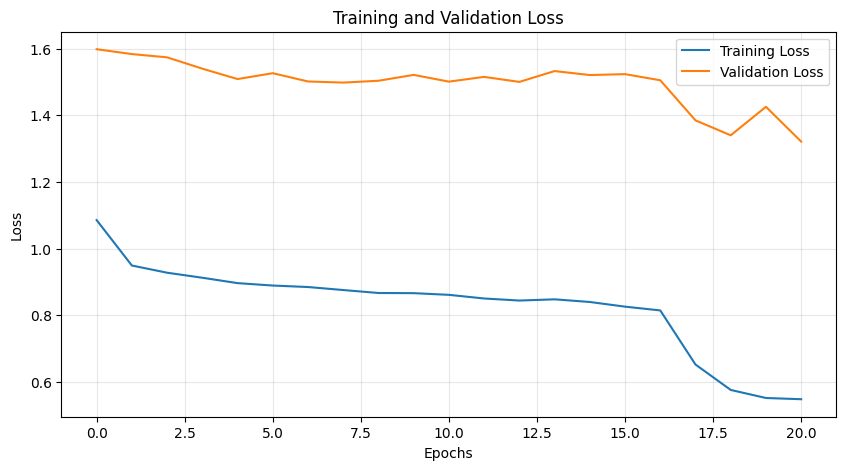

In [ ]:
# Step 5 - Report: Plot Loss
HISTORY_FILE = "/content/drive/MyDrive/ANN_Project/model/training_history.csv"

def plot_loss_only(file_path):
    print(f"Attempting to load history from: {file_path}")

    if not os.path.exists(file_path):
        print(f"❌ Error: File not found at {file_path}")
        return

    # Load CSV
    try:
        history = pd.read_csv(file_path)
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return

    # Check required columns
    if 'loss' not in history.columns or 'val_loss' not in history.columns:
        print("❌ Error: 'loss' or 'val_loss' columns missing in file.")
        print(f"Available columns: {list(history.columns)}")
        return

    # Extract
    loss = history['loss']
    val_loss = history['val_loss']
    epochs_range = range(len(loss))

    # Plot only loss
    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.show()

# Run
plot_loss_only(HISTORY_FILE)

Attempting to load validation data from: /content/drive/MyDrive/ANN_Project/model
✅ Loaded Successfully: X=(702, 128, 128, 64), y=(702, 128, 128, 1)
✅ Model loaded from /content/drive/MyDrive/ANN_Project/model/best_model.keras
Predicting on validation data...
22/22 [==============================] - 14s 317ms/step

--- Classification Report ---
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00  11414759
    Mangrove       0.60      0.73      0.66     86809

    accuracy                           0.99  11501568
   macro avg       0.80      0.87      0.83  11501568
weighted avg       0.99      0.99      0.99  11501568



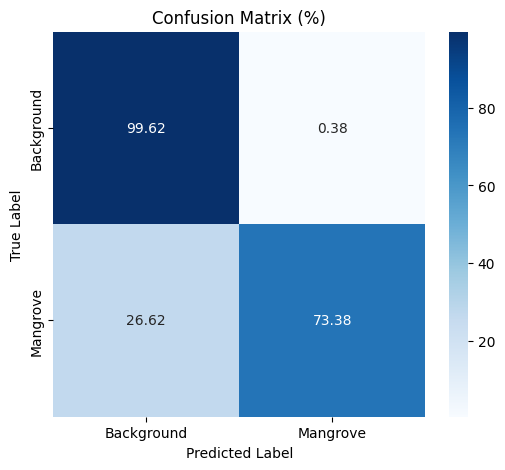


IoU (Mangrove class): 0.4899
ROC AUC: 0.9814
PR AUC: 0.7163 (important for imbalanced data)


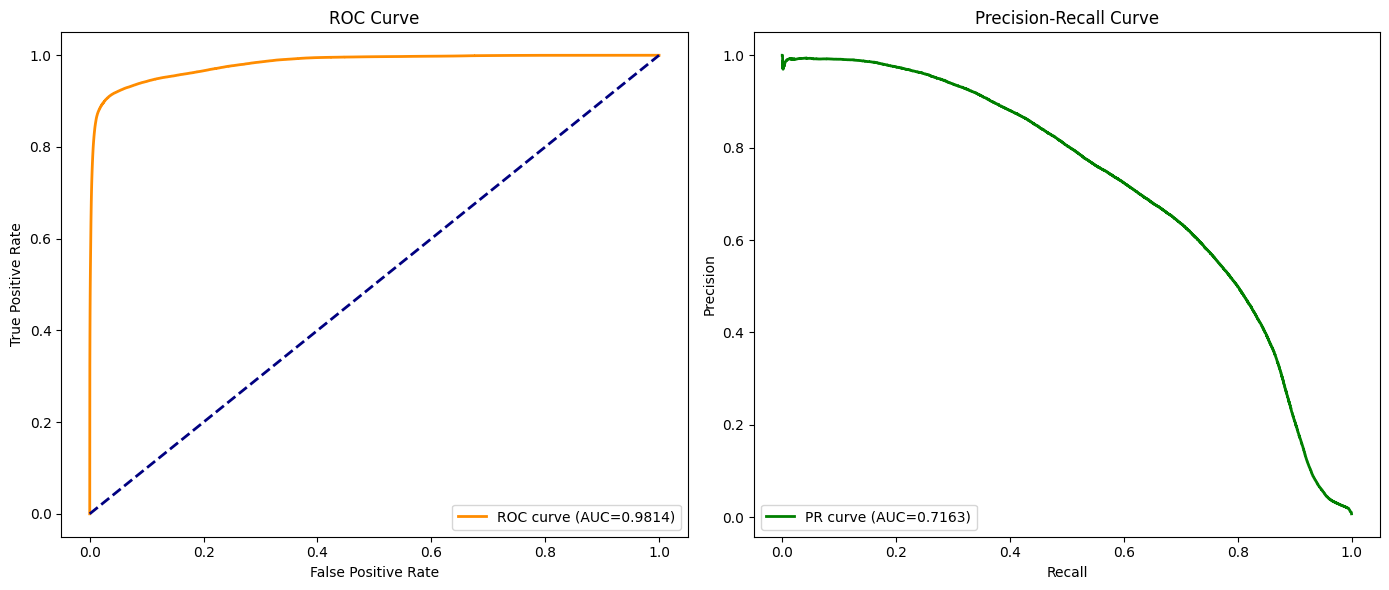

In [ ]:
# --- 1. Load Validation Data ---
SAVE_DIR = "/content/drive/MyDrive/ANN_Project/model"
x_path = os.path.join(SAVE_DIR, "X_val.npy")
y_path = os.path.join(SAVE_DIR, "y_val.npy")

print(f"Attempting to load validation data from: {SAVE_DIR}")
if os.path.exists(x_path) and os.path.exists(y_path):
    X_val = np.load(x_path)
    y_val = np.load(y_path)
    print(f"✅ Loaded Successfully: X={X_val.shape}, y={y_val.shape}")
else:
    raise FileNotFoundError("X_val.npy or y_val.npy not found. Run the 'Save Validation Data' step first.")

# --- 2. Load Model if needed ---
if 'model' not in locals():
    model_path = os.path.join(SAVE_DIR, "best_model.keras")
    try:
        model = tf_keras.models.load_model(model_path, compile=False)
    except:
        model = tf.keras.models.load_model(model_path, compile=False)
    print(f"✅ Model loaded from {model_path}")

# --- 3. Evaluation Function ---
def evaluate_model(model, X_val, y_val, threshold=0.5):
    print("Predicting on validation data...")
    predictions = model.predict(X_val, verbose=1)

    # Handle deep-supervision
    y_pred_prob = predictions[0] if isinstance(predictions, list) else predictions

    # Flatten for metrics
    y_true_flat = y_val.flatten().astype(int)
    y_scores_flat = y_pred_prob.flatten()
    y_pred_flat = (y_scores_flat > threshold).astype(int)

    # --- Classification Report ---
    print("\n--- Classification Report ---")
    report = classification_report(y_true_flat, y_pred_flat, target_names=['Background', 'Mangrove'])
    print(report)

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8) * 100

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=['Background','Mangrove'],
                yticklabels=['Background','Mangrove'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (%)')
    plt.show()

    # --- IoU Calculation ---
    intersection = np.logical_and(y_true_flat, y_pred_flat).sum()
    union = np.logical_or(y_true_flat, y_pred_flat).sum()
    iou_score = intersection / (union + 1e-8)
    print(f"\nIoU (Mangrove class): {iou_score:.4f}")

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true_flat, y_scores_flat)
    roc_auc = auc(fpr, tpr)

    # --- Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_true_flat, y_scores_flat)
    pr_auc = average_precision_score(y_true_flat, y_scores_flat)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f} (important for imbalanced data)")

    # --- Plot ROC & PRC ---
    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC={roc_auc:.4f})')
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.subplot(1,2,2)
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC={pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

# --- 4. Run Evaluation ---
evaluate_model(model, X_val, y_val)

In [ ]:
# Step 6 - Evaluation on Umm Al Quwain Data (Raw Prediction Only)
def predict_large_image(model, img_array, tile_size=128):
    """
    Predict on large image with tiling.
    NO TTA. Returns raw probability map (H, W, 1).
    """
    h, w, c = img_array.shape
    pad_h = (tile_size - (h % tile_size)) % tile_size
    pad_w = (tile_size - (w % tile_size)) % tile_size
    img_padded = np.pad(img_array, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')

    ph, pw, _ = img_padded.shape
    prob_map = np.zeros((ph, pw, 1), dtype=np.float32)

    for i in range(0, ph, tile_size):
        for j in range(0, pw, tile_size):
            tile = img_padded[i:i+tile_size, j:j+tile_size, :]
            tile_batch = tf.expand_dims(tile, axis=0)

            # Direct Prediction (No TTA loops)
            pred = model.predict(tile_batch, verbose=0)

            # Handle Deep Supervision (Model returns [Final, Aux1, Aux2])
            if isinstance(pred, list):
                pred = pred[0] # Take the first output (Final)

            # Assign to map
            prob_map[i:i+tile_size, j:j+tile_size, :] = pred[0]

    return prob_map[:h, :w, :]

IoU (Mangrove): 0.5752

--- Classification Report ---
              precision    recall  f1-score   support

  Background       0.98      0.95      0.97    679371
    Mangrove       0.64      0.85      0.73     65895

    accuracy                           0.94    745266
   macro avg       0.81      0.90      0.85    745266
weighted avg       0.95      0.94      0.95    745266



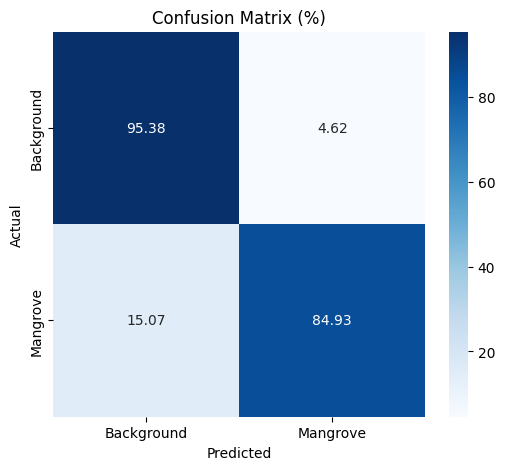

ROC AUC: 0.9724
PR AUC: 0.7497


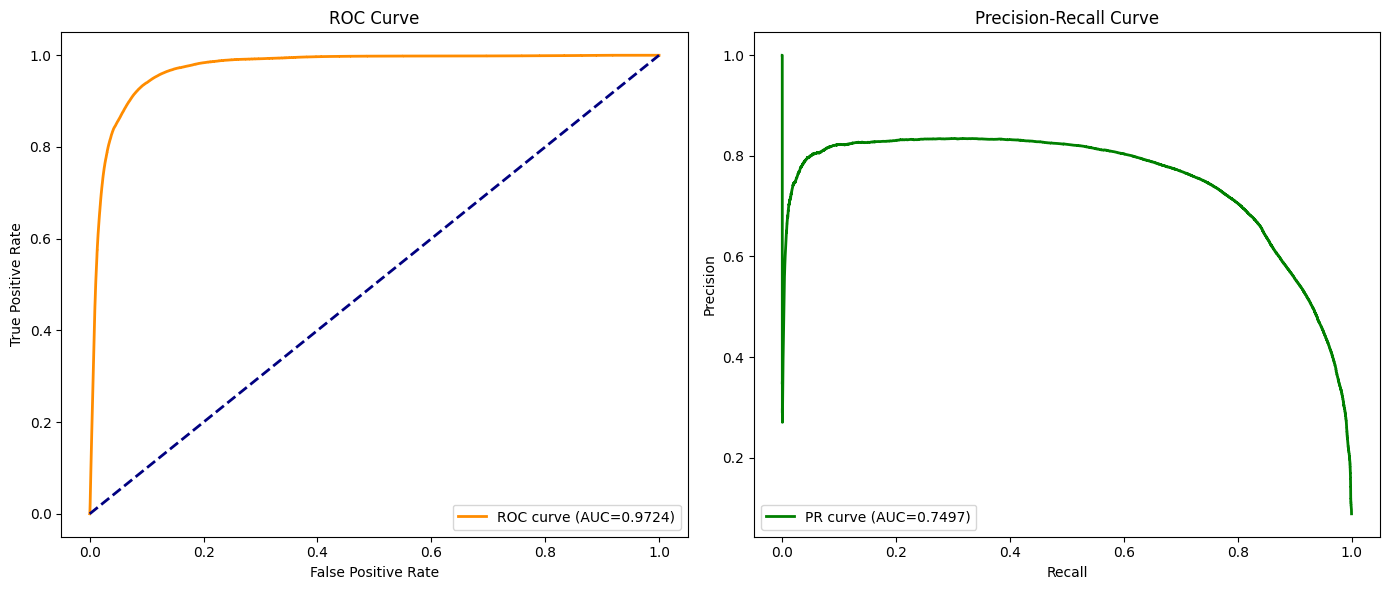

In [ ]:
# MAIN EVALUATION LOOP
THRESHOLD = 0.5
MODEL_PATH = "/content/drive/MyDrive/ANN_Project/model/best_model.keras"

# Load model
try:
    model = tf_keras.models.load_model(MODEL_PATH, compile=False)
except:
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# Load DE and GMW corrected TIFFs
# NOTE: Ensure these point to the correct region/years you want to test
input_path = f"{DE_CORRECTED}/{TEST_REGION}/2019.tif"
target_path = f"{GMW_CORRECTED}/{TEST_REGION}/2020.tif"

with rasterio.open(input_path) as src_input:
    img_input = src_input.read().transpose(1,2,0)
    master_transform = src_input.transform
    master_crs = src_input.crs
    H, W = src_input.shape

with rasterio.open(target_path) as src_target:
    gmw_aligned = np.zeros((H, W), dtype=src_target.dtypes[0])
    reproject(
        source=rasterio.band(src_target, 1),
        destination=gmw_aligned,
        src_transform=src_target.transform,
        src_crs=src_target.crs,
        dst_transform=master_transform,
        dst_crs=master_crs,
        resampling=Resampling.nearest
    )
    gmw_actual = (gmw_aligned > 0).astype(int)

# --- Predict ---
pred_prob_map = predict_large_image(model, img_input, tile_size=TILE_SIZE)
pred_binary = (pred_prob_map[..., 0] > THRESHOLD).astype(int)

# Safety crop/pad
if pred_binary.shape != gmw_actual.shape:
    h_min = min(pred_binary.shape[0], gmw_actual.shape[0])
    w_min = min(pred_binary.shape[1], gmw_actual.shape[1])
    pred_binary = pred_binary[:h_min, :w_min]
    gmw_actual = gmw_actual[:h_min, :w_min]

# --- Flatten for metrics ---
flat_true = gmw_actual.flatten()
flat_pred = pred_binary.flatten()
flat_scores = pred_prob_map[..., 0].flatten()

# --- IoU ---
iou_score = jaccard_score(flat_true, flat_pred)
print(f"IoU (Mangrove): {iou_score:.4f}")

# --- Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(flat_true, flat_pred, target_names=['Background','Mangrove']))

# --- Confusion Matrix ---
cm = confusion_matrix(flat_true, flat_pred)
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8) * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=['Background','Mangrove'],
            yticklabels=['Background','Mangrove'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)')
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(flat_true, flat_scores)
roc_auc = auc(fpr, tpr)

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(flat_true, flat_scores)
pr_auc = average_precision_score(flat_true, flat_scores)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# --- Plot ROC & PRC ---
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC={roc_auc:.4f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC={pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

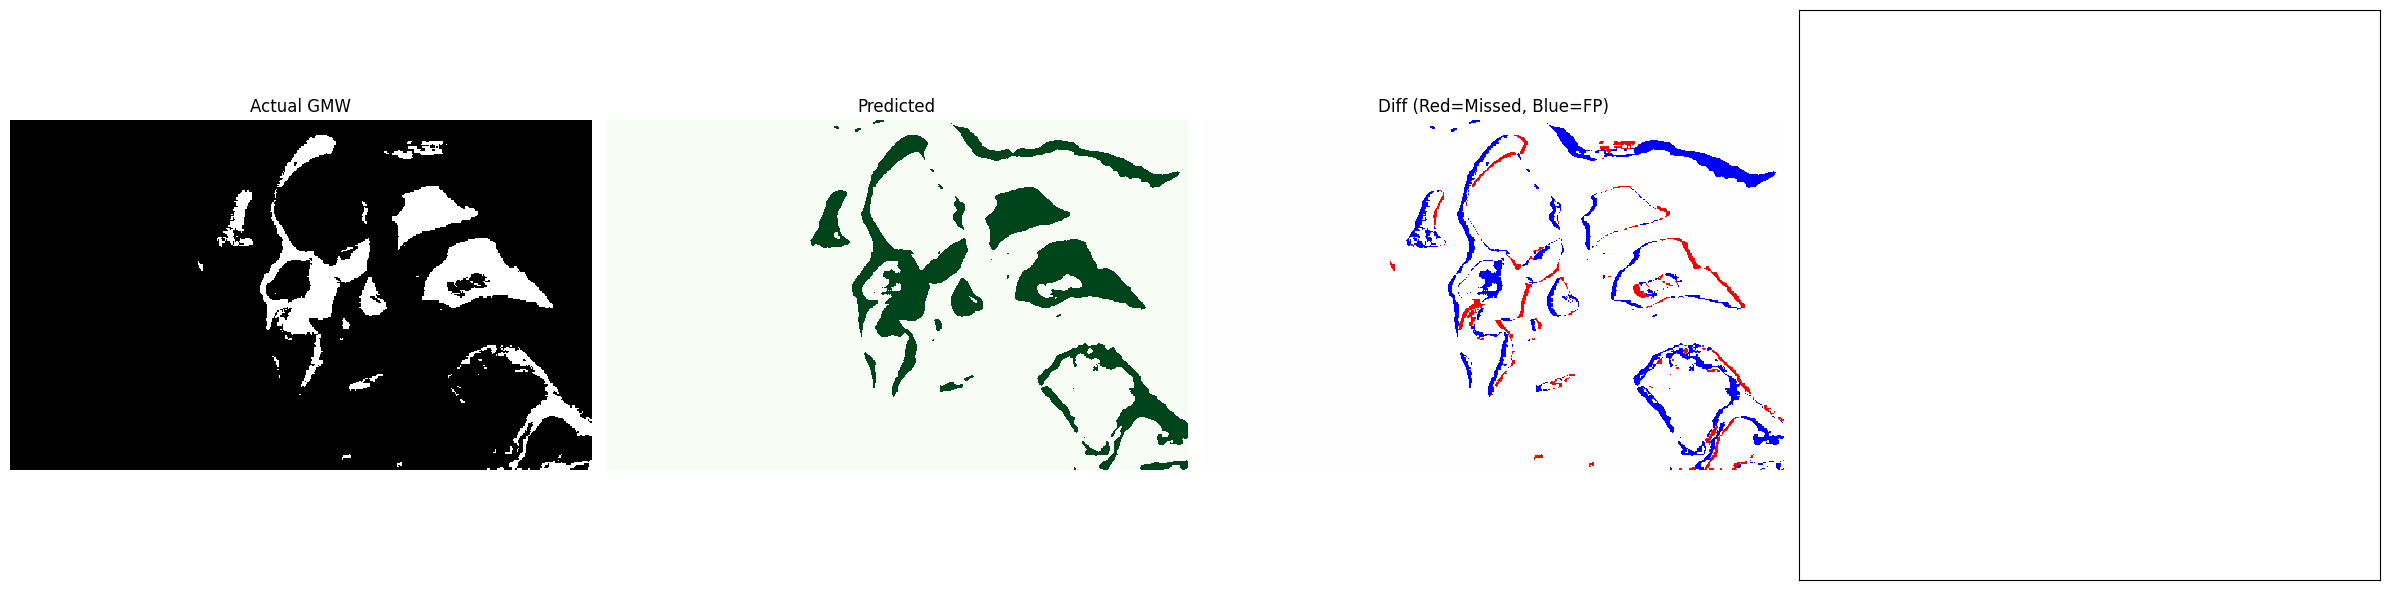

In [ ]:
# Visualization
flat_true = gmw_actual.flatten()
flat_pred = pred_binary.flatten()

# Confusion matrix
cm = confusion_matrix(flat_true, flat_pred)
# Normalize, handling zero division safely
cm_sum = cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm.astype('float') / (cm_sum + 1e-8) * 100

# Difference map
diff = pred_binary - gmw_actual

# Plot full 4-panel
fig, ax = plt.subplots(1, 4, figsize=(24,6))

ax[0].imshow(gmw_actual, cmap='gray', interpolation='none')
ax[0].set_title(f"Actual GMW")
ax[1].imshow(pred_binary, cmap='Greens', interpolation='none')
ax[1].set_title("Predicted")
ax[2].imshow(diff, cmap='bwr_r', vmin=-1, vmax=1, interpolation='none')
ax[2].set_title("Diff (Red=Missed, Blue=FP)")

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

ax[3].set_xticks([])
ax[3].set_yticks([])
plt.tight_layout()
plt.show()

--- MANGROVE CHANGE STATISTICS ---
Baseline Pixels:      72,727
Target Actual Pixels: 65,895
Target Pred Pixels:   87,357
------------------------------
Actual Change:    -6,832 pixels (-9.39%)
Predicted Change: +14,630 pixels (+20.12%)
------------------------------


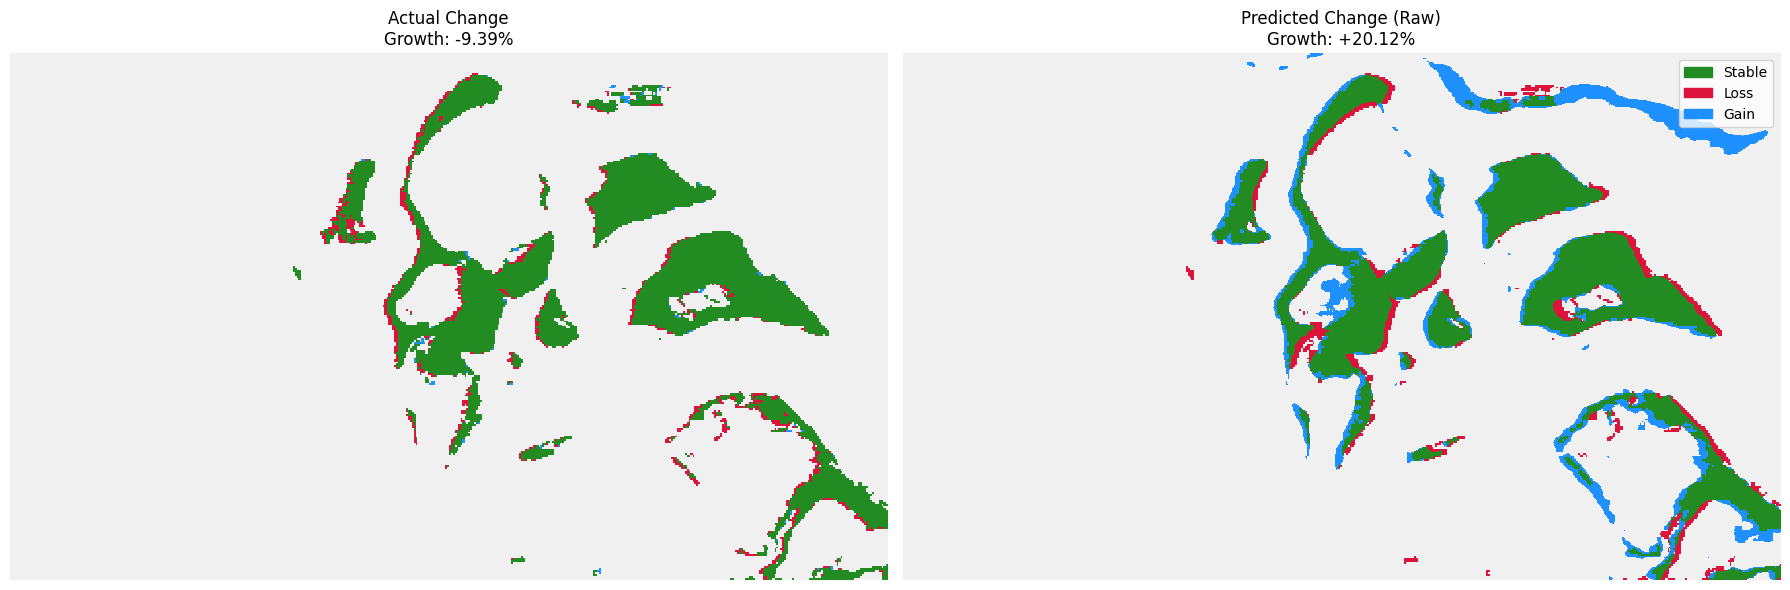

In [ ]:
# 1. Load Baseline GMW (e.g. 2018)
gmw_19_path = f"{GMW_CORRECTED}/{TEST_REGION}/2019.tif" # Ensure this matches your logic

with rasterio.open(gmw_19_path) as src_19:
    gmw_19 = (src_19.read(1) > 0).astype(int)

clean_pred = pred_binary
flat_clean = clean_pred.flatten()
# Resize Baseline if necessary
if clean_pred.shape != gmw_19.shape:
    print(f"Resizing GMW Baseline from {gmw_19.shape} to {clean_pred.shape}...")
    gmw_tensor = tf.expand_dims(tf.expand_dims(gmw_19, -1), 0)
    gmw_resized = tf.image.resize(gmw_tensor, clean_pred.shape, method='nearest')
    gmw_19 = gmw_resized[0, ..., 0].numpy().astype(int)

# 2. Calculate Statistics
count_19 = np.sum(gmw_19)
count_20_actual = np.sum(gmw_actual)
count_20_pred = np.sum(clean_pred)

delta_actual = count_20_actual - count_19
delta_pred = count_20_pred - count_19

pct_change_actual = (delta_actual / count_19) * 100 if count_19 > 0 else 0
pct_change_pred = (delta_pred / count_19) * 100 if count_19 > 0 else 0

print(f"--- MANGROVE CHANGE STATISTICS ---")
print(f"Baseline Pixels:      {count_19:,}")
print(f"Target Actual Pixels: {count_20_actual:,}")
print(f"Target Pred Pixels:   {count_20_pred:,}")
print("-" * 30)
print(f"Actual Change:    {delta_actual:+,} pixels ({pct_change_actual:+.2f}%)")
print(f"Predicted Change: {delta_pred:+,} pixels ({pct_change_pred:+.2f}%)")
print("-" * 30)

# 3. Visualization
def create_change_map(prev, curr):
    change_map = np.zeros_like(prev)
    change_map[(prev == 1) & (curr == 1)] = 1 # Stable
    change_map[(prev == 1) & (curr == 0)] = 2 # Loss
    change_map[(prev == 0) & (curr == 1)] = 3 # Gain
    return change_map

map_actual_change = create_change_map(gmw_19, gmw_actual)
map_pred_change = create_change_map(gmw_19, clean_pred)

colors = ['#f0f0f0', '#228B22', '#DC143C', '#1E90FF']
labels = ['Background', 'Stable', 'Loss', 'Gain']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4], cmap.N)

fig, ax = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

ax[0].imshow(map_actual_change, cmap=cmap, norm=norm, interpolation='none')
ax[0].set_title(f"Actual Change\nGrowth: {pct_change_actual:+.2f}%")
ax[0].axis('off')

ax[1].imshow(map_pred_change, cmap=cmap, norm=norm, interpolation='none')
ax[1].set_title(f"Predicted Change (Raw)\nGrowth: {pct_change_pred:+.2f}%")
ax[1].axis('off')

patches = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(1,4)]
ax[1].legend(patches, labels[1:], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Step 7 - Lovasz fine tuning to see if it improves results
SOURCE_PATH = "/content/drive/MyDrive/ANN_Project/model"
# Create a backup using a descriptive name
BACKUP_PATH = "/content/drive/MyDrive/ANN_Project/model/best_model_focaldice_backup.keras"

if os.path.exists(SOURCE_PATH):
    shutil.copy2(SOURCE_PATH, BACKUP_PATH)
    print(f"✅ Model backed up successfully to: {BACKUP_PATH}")
else:
    print(f"❌ Error: Model not found at {SOURCE_PATH}")



In [ ]:
# --- Utility Functions for Lovász Loss ---

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovász extension w.r.t. sorted errors
    (for binary case).

    Args:
        gt_sorted (Tensor): Ground truth labels sorted by predicted error/score.

    Returns:
        Tensor: Lovász gradient.
    """
    g = tf.reduce_sum(gt_sorted, keepdims=True)

    # Calculate Jaccard score (IoU) for all prefixes
    intersection = g - tf.cumsum(gt_sorted)
    union = g + tf.cumsum(1.0 - gt_sorted)
    jaccard = 1.0 - intersection / union

    # Calculate the reduction for the Lovász gradient
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Lovász Hinge Loss for segmentation.

    Args:
        logits (Tensor): Predicted raw scores (before sigmoid).
        labels (Tensor): True labels (0 or 1).
        per_image (bool): If True, compute Lovász loss per image.
        ignore (int or None): Class label to ignore.

    Returns:
        Tensor: The Lovász Hinge loss value.
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            return lovasz_hinge(log, lab, per_image=False, ignore=ignore)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        return tf.reduce_mean(losses)

    # --- Flattening and Error Calculation ---
    labels = K.cast(labels, dtype=tf.float32)
    logits = K.flatten(logits)
    labels = K.flatten(labels)

    if ignore is not None:
        valid_indices = tf.where(tf.not_equal(labels, ignore))
        logits = tf.gather_nd(logits, valid_indices)
        labels = tf.gather_nd(labels, valid_indices)

    # Error for the hinge loss: max(1 - 2*labels*predictions, 0)
    # where predictions is 2*sigmoid(logits) - 1 (a mapping to [-1, 1])
    # For Lovasz Hinge, we use max(0, 1 + logit) if label=0, or max(0, 1 - logit) if label=1

    # Calculate errors e_i = 1 - p_i if label=1, or p_i if label=0
    errors = tf.abs(labels - tf.sigmoid(logits))

    # Sort the errors and the corresponding ground truth labels
    indices = tf.argsort(errors, direction='DESCENDING')
    errors_sorted = tf.gather(errors, indices)
    labels_sorted = tf.gather(labels, indices)

    # Compute the Lovász gradient and loss
    grad = lovasz_grad(labels_sorted)
    loss = tf.tensordot(errors_sorted, tf.stop_gradient(grad), 1)

    return loss

# --- Main Keras Wrapper ---

def lovasz_loss(y_true, y_pred):
    """
    Keras compatible wrapper for Lovász Hinge Loss.

    Args:
        y_true (Tensor): True labels (H, W, 1).
        y_pred (Tensor): Predicted probabilities (H, W, 1).

    Returns:
        Tensor: The mean loss over the batch.
    """
    # y_pred comes from sigmoid, so it's probabilities. We pass it through
    # a pseudo-logit transformation (inverse sigmoid) for the hinge loss calculation.
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    logits = tf.math.log(y_pred / (1.0 - y_pred))

    return lovasz_hinge(logits, y_true, per_image=True)

In [ ]:
# --- Configuration ---
SAVE_DIR = "/content/drive/MyDrive/nn_proj/model"
LOAD_PATH = os.path.join(SAVE_DIR, "best_model.keras")
FINE_TUNED_PATH = os.path.join(SAVE_DIR, "best_model_lovasz_finetuned.keras")
NEW_LEARNING_RATE = 1e-5 # Crucially low learning rate for fine-tuning

# Load the model with custom loss argument (necessary because we will recompile later)
try:
    print(f"Loading best model from {LOAD_PATH}...")
    model = tf_keras.models.load_model(LOAD_PATH, compile=False)

    # Backup step (already discussed, but included for completeness)
    BACKUP_PATH = os.path.join(SAVE_DIR, "best_model_bce_backup.keras")
    if not os.path.exists(BACKUP_PATH):
        model.save(BACKUP_PATH)
        print(f"✅ Backup created at {BACKUP_PATH}")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    # Handle model not found error (e.g., raise or exit)
    raise

# --- Freezing Layers ---
print("Freezing layers for Lovász fine-tuning...")

# Identify the split point (e.g., freeze the first half of the layers, which is usually the encoder)
total_layers = len(model.layers)
# Assuming a standard U-Net, we often freeze 50-70% of the layers.
# Let's freeze the first 60% of the layers, ensuring the core feature extraction is locked.
freeze_index = int(total_layers * 0.6)

for i, layer in enumerate(model.layers):
    if i < freeze_index:
        layer.trainable = False
    else:
        layer.trainable = True

print(f"Total layers: {total_layers}. Layers frozen: {freeze_index}.")
print(f"First trainable layer index: {freeze_index}.")

# Print layer names to confirm (optional)
# for layer in model.layers:
#     print(f"Layer: {layer.name}, Trainable: {layer.trainable}")

print(f"✅ Model prepared for fine-tuning with {total_layers - freeze_index} trainable layers.")

Loading best model from /content/drive/MyDrive/ANN_Project/model/best_model.keras...
✅ Backup created at /content/drive/MyDrive/ANN_Project/model/best_model_focaldice_backup.keras
Freezing layers for Lovász fine-tuning...
Total layers: 86. Layers frozen: 51.
First trainable layer index: 51.
✅ Model prepared for fine-tuning with 35 trainable layers.


In [ ]:
# --- Compilation for Fine-Tuning ---
# We use the custom defined lovasz_loss function
# Note: You may need to include 'MeanIoU' if your model uses it as a metric
metrics = ['accuracy', tf_keras.metrics.MeanIoU(num_classes=2)]

model.compile(
    optimizer=tf_keras.optimizers.AdamW(learning_rate=NEW_LEARNING_RATE),
    loss=lovasz_loss,
    metrics=metrics
)

print("\n--- Model Compilation for Lovász Fine-Tuning Complete ---")
print(f"New Loss: Lovász Hinge Loss")
print(f"New Learning Rate: {NEW_LEARNING_RATE}")
print(f"Metrics: {metrics}")

# --- Training / Fine-Tuning ---
# Assuming X_train and y_train are already loaded and defined
# Define your fine-tuning parameters
FINE_TUNING_EPOCHS = 2

# --- Callbacks for Fine-Tuning ---
ft_callbacks = []

print(f"\nStarting Lovász Fine-Tuning for {FINE_TUNING_EPOCHS} epochs...")

# NOTE: Replace X_train, y_train, X_val, y_val with your loaded data variables.
# Assuming X_val and y_val were loaded from Step 5.
history_ft = model.fit(
    train_ds,
    epochs=FINE_TUNING_EPOCHS,
    validation_data=val_ds, # Use validation dataset directly
    callbacks=ft_callbacks,
    verbose=1
)

# --- Unconditional Save after Fine-Tuning ---
model.save(FINE_TUNED_PATH)
print(f"\n✅ Lovász fine-tuning complete. Model saved  to: {FINE_TUNED_PATH}")


--- Model Compilation for Lovász Fine-Tuning Complete ---
New Loss: Lovász Hinge Loss
New Learning Rate: 1e-05
Metrics: ['accuracy', 'val_mangrove_iou']

Starting Lovász Fine-Tuning for 2 epochs...
Epoch 1/2


TypeError: in user code:

    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 1152, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py", line 1246, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.12/dist-packages/tf_keras/src/metrics/base_metric.py", line 722, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: 'str' object is not callable


In [ ]:

def save_validation_data_ft(val_ds, save_dir, x_filename="X_val.npy", y_filename="y_val.npy"):
    """
    Iterates through the validation dataset (val_ds), aggregates inputs (X) and
    labels (y), and saves them as NumPy files to Google Drive.
    This version is specifically for fine-tuning validation data.
    """
    X_val_list = []
    y_val_list = []

    print("Aggregating fine-tuning validation dataset batches...")

    for X_batch, y_batch in val_ds:
        X_val_list.append(X_batch.numpy())
        y_val_list.append(y_batch.numpy())

    X_val = np.concatenate(X_val_list, axis=0)
    y_val = np.concatenate(y_val_list, axis=0)

    print(f"Aggregation complete. X_val_ft shape: {X_val.shape}, y_val_ft shape: {y_val.shape}")

    x_path = os.path.join(save_dir, x_filename)
    y_path = os.path.join(save_dir, y_filename)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    np.save(x_path, X_val)
    np.save(y_path, y_val)

    print(f"✅ Fine-tuning validation data successfully saved to: {save_dir}")
    return X_val, y_val




# --- Configuration (Based on previous context) ---
SAVE_DIR = "/content/drive/MyDrive/nn_proj/model"
LOVASZ_HISTORY_FILE = os.path.join(SAVE_DIR, "lovasz_finetuning_history.csv")

# Define NEW filenames for the fine-tuning validation data
X_VAL_FT_FILE = "X_val_ft.npy"
Y_VAL_FT_FILE = "y_val_ft.npy"


# =================================================================
# 1. Save Lovász Fine-Tuning History
# (This part remains the same)
# =================================================================

if 'history_ft' in locals() and hasattr(history_ft, 'history'):
    # Convert the Keras History object's history dictionary to a pandas DataFrame
    lovasz_history_df = pd.DataFrame(history_ft.history)

    # Ensure the directory exists before saving
    history_dir = os.path.dirname(LOVASZ_HISTORY_FILE)
    if not os.path.exists(history_dir):
        os.makedirs(history_dir, exist_ok=True)

    # Save the DataFrame to CSV on Google Drive
    lovasz_history_df.to_csv(LOVASZ_HISTORY_FILE, index=False)
    print(f"\n✅ Lovász Fine-Tuning history saved successfully to: {LOVASZ_HISTORY_FILE}")
else:
    print("\n⚠️ history_ft object (Lovász fine-tuning) not found. Skipping history save.")


# =================================================================
# 2. Save Validation Data (with unique names)
# =================================================================
# This ensures X_val_ft.npy and y_val_ft.npy are saved, preserving the original X_val/y_val.

try:
    X_val_ft, y_val_ft = save_validation_data_ft(
        val_ds,
        SAVE_DIR,
        x_filename=X_VAL_FT_FILE,
        y_filename=Y_VAL_FT_FILE
    )
    print(f"✅ Fine-Tuned Validation Data Saved Successfully: {X_VAL_FT_FILE} ({X_val_ft.shape}), {Y_VAL_FT_FILE} ({y_val_ft.shape})")
except NameError:
    print("\n❌ Error: The required function 'save_validation_data' or the object 'val_ds' is not defined.")
    print("Please ensure your utility function and validation dataset are available.")
except Exception as e:
    print(f"\n❌ Error saving validation data: {e}")

In [ ]:
# Report: Plot Loss
HISTORY_FILE = "/content/drive/MyDrive/nn_proj/model/lovasz_finetuning_history.csv"

def plot_loss_only(file_path):
    print(f"Attempting to load history from: {file_path}")

    if not os.path.exists(file_path):
        print(f"❌ Error: File not found at {file_path}")
        return

    # Load CSV
    try:
        history = pd.read_csv(file_path)
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return

    # Check required columns
    if 'loss' not in history.columns or 'val_loss' not in history.columns:
        print("❌ Error: 'loss' or 'val_loss' columns missing in file.")
        print(f"Available columns: {list(history.columns)}")
        return

    # Extract
    loss = history['loss']
    val_loss = history['val_loss']
    epochs_range = range(len(loss))

    # Plot only loss
    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.show()

# Run
plot_loss_only(HISTORY_FILE)

In [ ]:
# MAIN EVALUATION LOOP
THRESHOLD = 0.5
MODEL_PATH = "/content/drive/MyDrive/nn_proj/model/best_model_lovasz_finetuned.keras"

from sklearn.metrics import roc_auc_score, roc_curve,precision_recall_curve, average_precision_score, auc
# Load model
try:
    model = tf_keras.models.load_model(MODEL_PATH, compile=False)
except:
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# Load DE and GMW corrected TIFFs
# NOTE: Ensure these point to the correct region/years you want to test
input_path = f"{DE_CORRECTED}/{TEST_REGION}/2019.tif"
target_path = f"{GMW_CORRECTED}/{TEST_REGION}/2020.tif"

with rasterio.open(input_path) as src_input:
    img_input = src_input.read().transpose(1,2,0)
    master_transform = src_input.transform
    master_crs = src_input.crs
    H, W = src_input.shape

with rasterio.open(target_path) as src_target:
    gmw_aligned = np.zeros((H, W), dtype=src_target.dtypes[0])
    reproject(
        source=rasterio.band(src_target, 1),
        destination=gmw_aligned,
        src_transform=src_target.transform,
        src_crs=src_target.crs,
        dst_transform=master_transform,
        dst_crs=master_crs,
        resampling=Resampling.nearest
    )
    gmw_actual = (gmw_aligned > 0).astype(int)

# --- Predict ---
pred_prob_map = predict_large_image(model, img_input, tile_size=TILE_SIZE)
pred_binary = (pred_prob_map[..., 0] > THRESHOLD).astype(int)

# Safety crop/pad
if pred_binary.shape != gmw_actual.shape:
    h_min = min(pred_binary.shape[0], gmw_actual.shape[0])
    w_min = min(pred_binary.shape[1], gmw_actual.shape[1])
    pred_binary = pred_binary[:h_min, :w_min]
    gmw_actual = gmw_actual[:h_min, :w_min]

# --- Flatten for metrics ---
flat_true = gmw_actual.flatten()
flat_pred = pred_binary.flatten()
flat_scores = pred_prob_map[..., 0].flatten()

# --- IoU ---
iou_score = jaccard_score(flat_true, flat_pred)
print(f"IoU (Mangrove): {iou_score:.4f}")

# --- Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(flat_true, flat_pred, target_names=['Background','Mangrove']))

# --- Confusion Matrix ---
cm = confusion_matrix(flat_true, flat_pred)
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8) * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=['Background','Mangrove'],
            yticklabels=['Background','Mangrove'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)')
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(flat_true, flat_scores)
roc_auc = auc(fpr, tpr)

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(flat_true, flat_scores)
pr_auc = average_precision_score(flat_true, flat_scores)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# --- Plot ROC & PRC ---
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC={roc_auc:.4f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC={pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

In [ ]:
clean_pred = pred_binary
flat_clean = clean_pred.flatten()

In [ ]:
# 1. Load Baseline GMW (e.g. 2018)
gmw_19_path = f"{GMW_CORRECTED}/{TEST_REGION}/2019.tif" # Ensure this matches your logic

with rasterio.open(gmw_19_path) as src_19:
    gmw_19 = (src_19.read(1) > 0).astype(int)

# Resize Baseline if necessary
if clean_pred.shape != gmw_19.shape:
    print(f"Resizing GMW Baseline from {gmw_19.shape} to {clean_pred.shape}...")
    gmw_tensor = tf.expand_dims(tf.expand_dims(gmw_19, -1), 0)
    gmw_resized = tf.image.resize(gmw_tensor, clean_pred.shape, method='nearest')
    gmw_19 = gmw_resized[0, ..., 0].numpy().astype(int)

# 2. Calculate Statistics
count_19 = np.sum(gmw_19)
count_20_actual = np.sum(gmw_actual)
count_20_pred = np.sum(clean_pred)

delta_actual = count_20_actual - count_19
delta_pred = count_20_pred - count_19

pct_change_actual = (delta_actual / count_19) * 100 if count_19 > 0 else 0
pct_change_pred = (delta_pred / count_19) * 100 if count_19 > 0 else 0

print(f"--- MANGROVE CHANGE STATISTICS ---")
print(f"Baseline Pixels:      {count_19:,}")
print(f"Target Actual Pixels: {count_20_actual:,}")
print(f"Target Pred Pixels:   {count_20_pred:,}")
print("-" * 30)
print(f"Actual Change:    {delta_actual:+,} pixels ({pct_change_actual:+.2f}%)")
print(f"Predicted Change: {delta_pred:+,} pixels ({pct_change_pred:+.2f}%)")
print("-" * 30)

# 3. Visualization
def create_change_map(prev, curr):
    change_map = np.zeros_like(prev)
    change_map[(prev == 1) & (curr == 1)] = 1 # Stable
    change_map[(prev == 1) & (curr == 0)] = 2 # Loss
    change_map[(prev == 0) & (curr == 1)] = 3 # Gain
    return change_map

map_actual_change = create_change_map(gmw_19, gmw_actual)
map_pred_change = create_change_map(gmw_19, clean_pred)

colors = ['#f0f0f0', '#228B22', '#DC143C', '#1E90FF']
labels = ['Background', 'Stable', 'Loss', 'Gain']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4], cmap.N)

fig, ax = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

ax[0].imshow(map_actual_change, cmap=cmap, norm=norm, interpolation='none')
ax[0].set_title(f"Actual Change\nGrowth: {pct_change_actual:+.2f}%")
ax[0].axis('off')

ax[1].imshow(map_pred_change, cmap=cmap, norm=norm, interpolation='none')
ax[1].set_title(f"Predicted Change (Raw)\nGrowth: {pct_change_pred:+.2f}%")
ax[1].axis('off')

patches = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(1,4)]
ax[1].legend(patches, labels[1:], loc='upper right')

plt.tight_layout()
plt.show()